In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
#from helper_functions import set_seeds

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
pip install torchinfo

In [5]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

#Helper Funcions

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests

from sklearn.metrics import precision_recall_curve


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


def plot_auc_roc(results):
    """Plot AUC-ROC curves for each class."""
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # Check if the results are stored as a list of tensors and concatenate if necessary
    y_true = results['test_true_labels']
    y_scores = results['test_scores']

    if isinstance(y_true, list):
        y_true = torch.cat(y_true)
    if isinstance(y_scores, list):
        y_scores = torch.cat(y_scores)

    # Calculate ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    num_classes = y_scores.shape[1]  # Assuming y_scores is now a tensor with the correct shape
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure()
        plt.plot(fpr[i], tpr[i], color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for class {i}')
        plt.legend(loc="lower right")
        plt.show()


def plot_precision_recall(results):
    """Plot precision-recall curves for each class."""
    y_true = results['test_true_labels']
    y_scores = results['test_scores']

    # Check if the results are stored as a list of tensors and concatenate if necessary
    if isinstance(y_true, list):
        y_true = torch.cat(y_true)
    if isinstance(y_scores, list):
        y_scores = torch.cat(y_scores)

    # Calculate precision-recall curve for each class
    num_classes = y_scores.shape[1]
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
        plt.figure()
        plt.step(recall, precision, where='post', color='b', alpha=0.7,
                 label=f'Class {i} Precision-Recall curve')
        plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'Precision-Recall curve for class {i}')
        plt.legend(loc="upper right")
        plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

def plot_confusion_matrix(model, dataloader, class_names, device):
    """Plot the confusion matrix using the model and dataloader to predict labels."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Example of calling the function
# Assuming you have `model`, `test_dataloader`, `class_names`, and `device` defined
# plot_confusion_matrix(model, test_dataloader, class_names, device)








# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [7]:
import os
import random
from typing import Dict, NamedTuple, Optional

import numpy as np

#from file_utils import is_tf_available, is_torch_available


try:
    import wandb

    wandb.ensure_configured()
    if wandb.api.api_key is None:
        _has_wandb = False
        wandb.termwarn("W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.")
    else:
        _has_wandb = False if os.getenv("WANDB_DISABLED") else True
except (ImportError, AttributeError):
    _has_wandb = False


def is_wandb_available():
    return _has_wandb


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf``
    (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        import torch

        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)



class EvalPrediction(NamedTuple):
    """
    Evaluation output (always contains labels), to be used to compute metrics.

    Parameters:
        predictions (:obj:`np.ndarray`): Predictions of the model.
        label_ids (:obj:`np.ndarray`): Targets to be matched.
    """

    predictions: np.ndarray
    label_ids: np.ndarray



class PredictionOutput(NamedTuple):
    predictions: np.ndarray
    label_ids: Optional[np.ndarray]
    metrics: Optional[Dict[str, float]]


class TrainOutput(NamedTuple):
    global_step: int
    training_loss: float


PREFIX_CHECKPOINT_DIR = "checkpoint"

In [8]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['acai','cupuacu','graviola','guarana','pupunha','tucuma']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 95.9MB/s]


In [9]:
# Genera una entrada de ejemplo
dummy_input = torch.randn(32, 3, 224, 224).to(device)

# Pasa la entrada a través del modelo
output = pretrained_vit(dummy_input)

# Imprime la forma de la salida
print(output.shape)  # Debería ser (32, 6) si el número de clases es 6

torch.Size([32, 6])


In [10]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [11]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/ds_frutas_am/train'
test_dir = '/content/drive/MyDrive/ds_frutas_am/test'

In [12]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

# Example transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform= transform ,
                                                                                          batch_size=32,
                                                                                          num_workers=0) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [15]:
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
import torchmetrics
from sklearn.metrics import matthews_corrcoef
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    total_samples = 0

    # Initialize torchmetrics for multiclass classification
    accuracy = torchmetrics.Accuracy(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    precision = torchmetrics.Precision(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    recall = torchmetrics.Recall(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    f1 = torchmetrics.F1Score(num_classes=len(class_names), average='macro', task='multiclass').to(device)

    mcc_scores = []
    all_true_labels = []
    all_pred_scores = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * X.size(0)
        total_samples += X.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        y_pred_class = y_pred.argmax(dim=1)
        accuracy.update(y_pred_class, y)
        precision.update(y_pred_class, y)
        recall.update(y_pred_class, y)
        f1.update(y_pred_class, y)

        # Store true labels and predictions
        all_true_labels.append(y.cpu())
        all_pred_scores.append(torch.softmax(y_pred, dim=1).cpu())

        # Convert to CPU and numpy for MCC calculation
        y_true = y.cpu().numpy()
        y_pred_np = y_pred_class.cpu().numpy()
        mcc_scores.append(matthews_corrcoef(y_true, y_pred_np))

    # Compute final metrics
    train_loss /= total_samples
    train_acc = accuracy.compute()
    train_pre = precision.compute()
    train_rec = recall.compute()
    train_f1 = f1.compute()
    train_mcc = np.mean(mcc_scores)  # Calculate mean MCC over all batches

    # Concatenate lists of batches into single tensors
    train_true_labels = torch.cat(all_true_labels)
    train_scores = torch.cat(all_pred_scores)

    return (train_loss, train_acc, train_pre, train_rec, train_f1, train_mcc), train_true_labels, train_scores


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    total_samples = 0

    # Initialize torchmetrics
    accuracy = torchmetrics.Accuracy(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    precision = torchmetrics.Precision(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    recall = torchmetrics.Recall(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    f1 = torchmetrics.F1Score(num_classes=len(class_names), average='macro', task='multiclass').to(device)

    mcc_scores = []
    all_true_labels = []
    all_pred_scores = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item() * X.size(0)
            total_samples += X.size(0)

            y_pred_class = y_pred.argmax(dim=1)
            accuracy.update(y_pred_class, y)
            precision.update(y_pred_class, y)
            recall.update(y_pred_class, y)
            f1.update(y_pred_class, y)

            # Store true labels and predictions
            all_true_labels.append(y.cpu())
            all_pred_scores.append(torch.softmax(y_pred, dim=1).cpu())

            # Convert to CPU and numpy for MCC calculation
            y_true = y.cpu().numpy()
            y_pred_np = y_pred_class.cpu().numpy()
            mcc_scores.append(matthews_corrcoef(y_true, y_pred_np))

    # Compute final metrics
    test_loss /= total_samples
    test_acc = accuracy.compute()
    test_pre = precision.compute()
    test_rec = recall.compute()
    test_f1 = f1.compute()
    test_mcc = np.mean(mcc_scores)  # Calculate mean MCC over all batches

    # Concatenate lists of batches into single tensors
    test_true_labels = torch.cat(all_true_labels)
    test_scores = torch.cat(all_pred_scores)

    return (test_loss, test_acc, test_pre, test_rec, test_f1, test_mcc, test_true_labels, test_scores), test_true_labels, test_scores

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> dict:
    """
    Trains and tests a PyTorch model, computing and storing training/testing metrics across epochs.

    Args:
        model: The model to be trained and tested.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer to use for training.
        loss_fn: Loss function used during training.
        epochs: Number of epochs to train for.
        device: Device to train on (e.g., 'cuda' or 'cpu').

    Returns:
        A dictionary containing lists of metrics for each epoch: training and testing loss, accuracy, precision, recall, F1 score, and MCC.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "train_pre": [],
        "train_rec": [],
        "train_f1": [],
        "train_mcc": [],
        "test_loss": [],
        "test_acc": [],
        "test_pre": [],
        "test_rec": [],
        "test_f1": [],
        "test_mcc": [],
        "test_true_labels": [],
        "test_scores": [],
        "train_true_labels": [],
        "train_scores": []
    }

    # Ensure model is on the right device
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Training step
        train_metrics, train_true_labels, train_scores = train_step(model, train_dataloader, loss_fn, optimizer, device)
        # Testing step
        test_metrics, test_true_labels, test_scores = test_step(model, test_dataloader, loss_fn, device)

        # Logging the metrics for each epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training -> Loss: {train_metrics[0]:.4f}, Acc: {train_metrics[1]:.4f}, "
              f"Precision: {train_metrics[2]:.4f}, Recall: {train_metrics[3]:.4f}, "
              f"F1: {train_metrics[4]:.4f}, MCC: {train_metrics[5]:.4f}")
        print(f"Testing  -> Loss: {test_metrics[0]:.4f}, Acc: {test_metrics[1]:.4f}, "
              f"Precision: {test_metrics[2]:.4f}, Recall: {test_metrics[3]:.4f}, "
              f"F1: {test_metrics[4]:.4f}, MCC: {test_metrics[5]:.4f}")

        # Storing metrics in results dictionary
        for key, metric_value in zip(results.keys(), train_metrics + test_metrics):
            results[key].append(metric_value)

        results['train_true_labels'].append(train_true_labels)
        results['train_scores'].append(train_scores)
        results['test_true_labels'].append(test_true_labels)
        results['test_scores'].append(test_scores)

    return results




In [16]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=200,
                                      device=device)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
Training -> Loss: 1.7732, Acc: 0.2333, Precision: 0.2563, Recall: 0.2333, F1: 0.2380, MCC: 0.0898
Testing  -> Loss: 1.6117, Acc: 0.3667, Precision: 0.3992, Recall: 0.3667, F1: 0.3741, MCC: 0.2423
Epoch 2/200
Training -> Loss: 1.3477, Acc: 0.7000, Precision: 0.7275, Recall: 0.7000, F1: 0.6819, MCC: 0.6525
Testing  -> Loss: 1.3217, Acc: 0.6000, Precision: 0.6167, Recall: 0.6000, F1: 0.5930, MCC: 0.5256
Epoch 3/200
Training -> Loss: 1.0255, Acc: 0.8333, Precision: 0.8506, Recall: 0.8333, F1: 0.8224, MCC: 0.8147
Testing  -> Loss: 1.0955, Acc: 0.7000, Precision: 0.7083, Recall: 0.7000, F1: 0.6970, MCC: 0.6426
Epoch 4/200
Training -> Loss: 0.7742, Acc: 0.9444, Precision: 0.9471, Recall: 0.9444, F1: 0.9443, MCC: 0.9377
Testing  -> Loss: 0.9201, Acc: 0.7667, Precision: 0.7750, Recall: 0.7667, F1: 0.7653, MCC: 0.7219
Epoch 5/200
Training -> Loss: 0.5919, Acc: 0.9667, Precision: 0.9700, Recall: 0.9667, F1: 0.9670, MCC: 0.9628
Testing  -> Loss: 0.7908, Acc: 0.8000, Precision: 0.8056, 

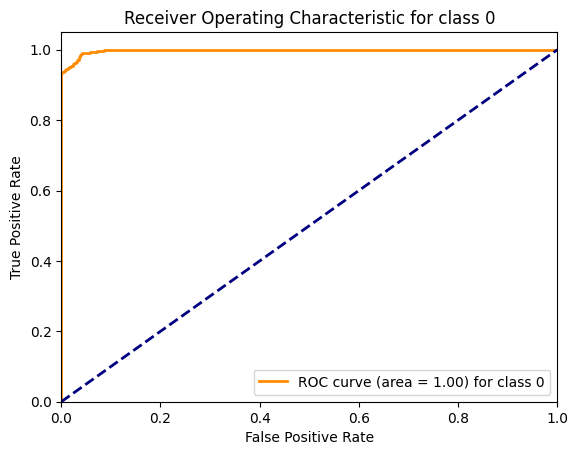

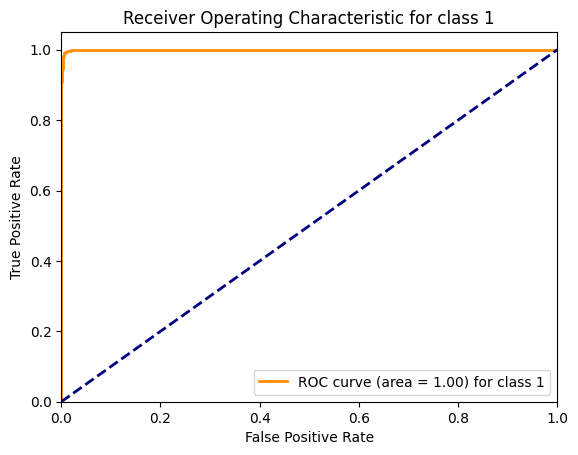

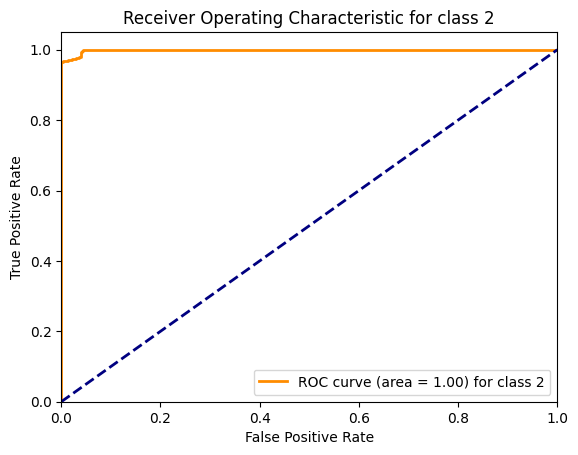

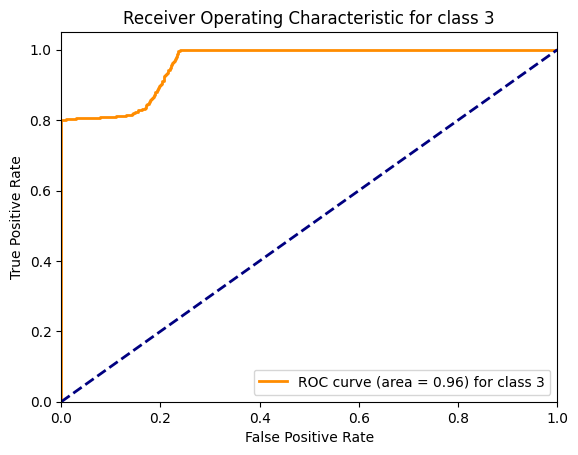

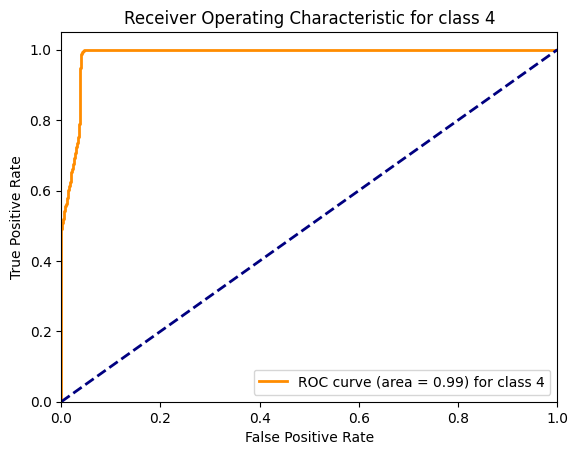

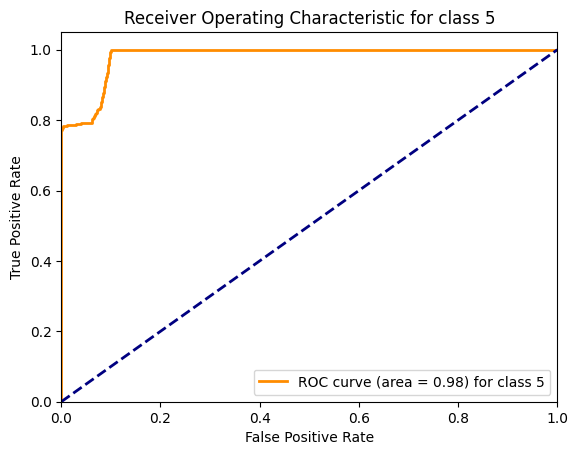

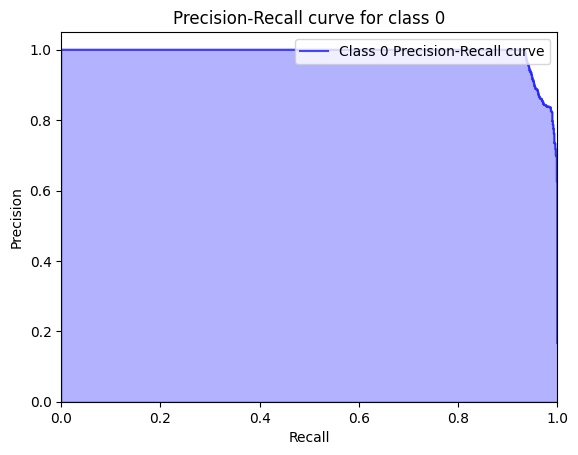

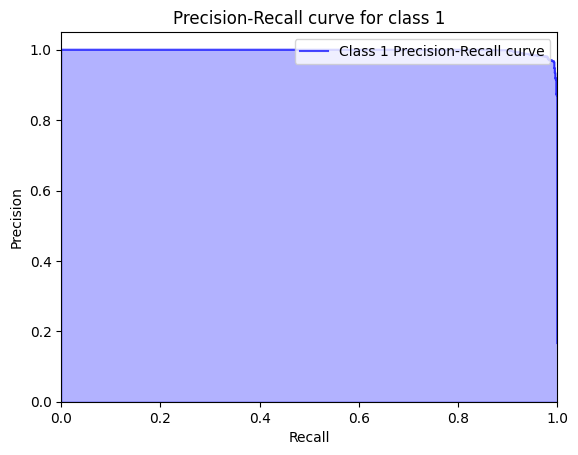

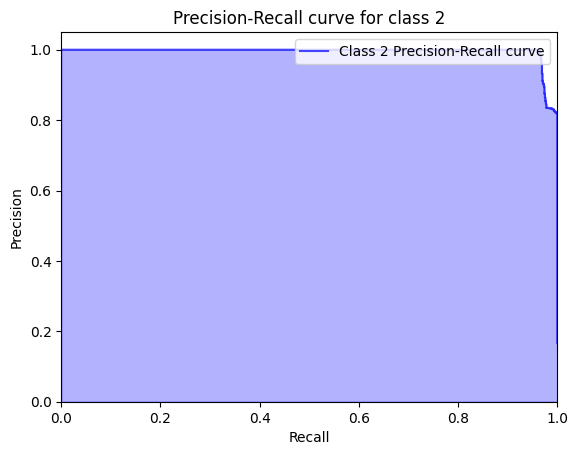

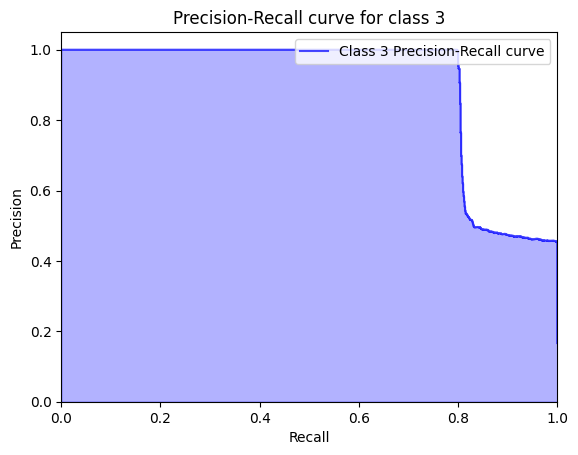

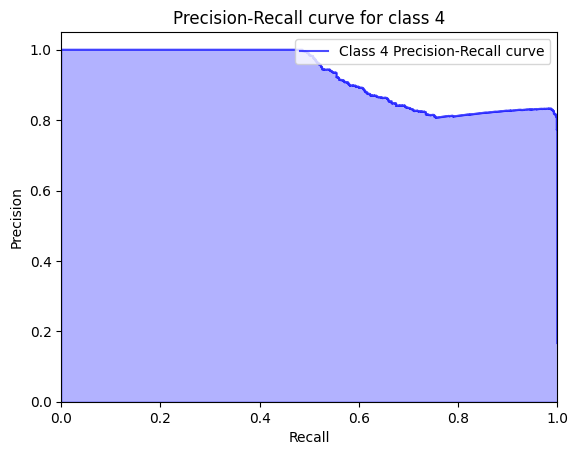

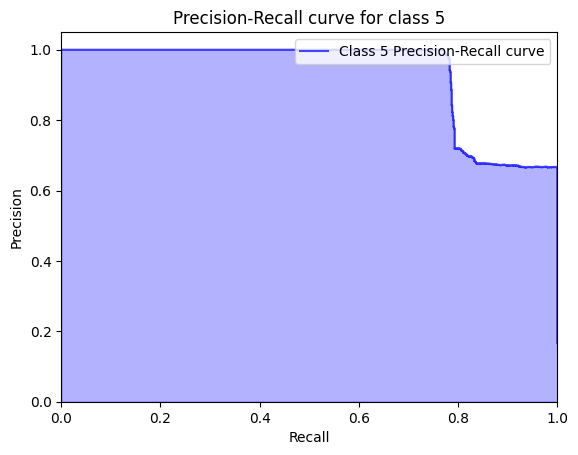

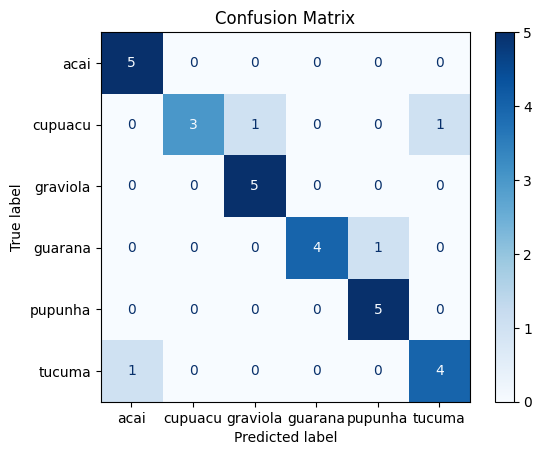

In [20]:
# Plot the loss curves
#plot_loss_curves(pretrained_vit_results)

plot_auc_roc(pretrained_vit_results)
plot_precision_recall(pretrained_vit_results)
# Example of how to call the function correctly
plot_confusion_matrix(pretrained_vit, test_dataloader_pretrained, class_names, device)


In [ ]:
print(pretrained_vit_results.keys())


dict_keys(['train_loss', 'train_acc', 'train_pre', 'train_rec', 'train_f1', 'train_mcc', 'test_loss', 'test_acc', 'test_pre', 'test_rec', 'test_f1', 'test_mcc'])


In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

In [ ]:
import requests


# Setup custom image path
custom_image_path = "/content/drive/MyDrive/ds_frutas_am/test_ind/test_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:


# Setup custom image path
custom_image_path = "/content/drive/MyDrive/ds_frutas_am/test_ind/test_2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Dropout, LayerNormalization, MultiHeadAttention, Embedding, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, log_loss
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset_dir = '/content/drive/MyDrive/fruits101/archive'

ViT

In [ ]:
def patch_encoder(inputs, num_patches, projection_dim):

    patch_dimension = tf.shape(inputs)[1] // num_patches
    patches = tf.reshape(inputs, [-1, num_patches, patch_dimension])

    posiciones = tf.range(num_patches, dtype=tf.float32)
    posiciones = tf.expand_dims(posiciones, 0)
    posiciones = tf.tile(posiciones, [tf.shape(inputs)[0], 1])
    posiciones_embeddings = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(posiciones)
    print('posicion embeddings ',posiciones_embeddings.shape)

    # Sumar incrustaciones de posición a los parches codificados
    encoded_patches = layers.Dense(units=projection_dim)(patches)
    print('parches codificados',encoded_patches)

    encoded_patches += posiciones_embeddings
    return encoded_patches


# modelo ViT
def create_vit_classifier(input_shape, num_patches, projection_dim, num_heads, transformer_layers, num_classes):
    entradas = layers.Input(shape=input_shape)
    c = patch_encoder(entradas, num_patches, projection_dim)

    for _ in range(transformer_layers):
        # Capa de atención multi-head
        c1 = layers.LayerNormalization(epsilon=1e-6)(c)
        attention_salida = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(c1, c1)
        c2 = c + attention_salida

        # Capa feedforward
        c3 = layers.LayerNormalization(epsilon=1e-6)(c2)
        c3 = layers.Dense(units=projection_dim, activation='relu')(c3)
        c = c2 + c3

    # Capa de salida
    representacion = layers.LayerNormalization(epsilon=1e-6)(c)
    representacion = layers.Flatten()(representacion)
    caracteristicas = layers.Dense(units=2000, activation='relu')(representacion)
    salidas = layers.Dense(units=num_classes, activation='softmax')(caracteristicas)

    # Crear el modelo
    model = tf.keras.Model(inputs=entradas, outputs=salidas)
    return model


In [ ]:
input_shape = (32, 32, 3)  # Tamaño de las imágenes de entrada
num_patches = 64  # Número de parches en los que se divide la imagen
projection_dim = 64  # Dimensión de proyección de los parches
num_heads = 4  # Número de cabezas de atención en las capas de atención multi-cabeza
transformer_layers = 4  # Número de capas Transformer
num_classes = 8

#num_patches = (32 // 16) * (32 // 16)


batch_size = 64
image_size = (32, 32)  # Tamaño de las imágenes
seed = 123  # Semilla para barajar los datos
n_splits = 10

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
mcc_scores = []
auc_scores = []
losses = []
confusion_matrices = []

# Cargar datos de imagen desde la carpeta
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,  # Proporción de datos a usar como conjunto de validación
    subset='training'  # Indica que este es el conjunto de entrenamiento
)


# etiquetas de clase
class_names = train_dataset.class_names

# Mapear etiquetas de texto a números enteros
label_map = {class_name: i for i, class_name in enumerate(class_names)}

# Obtener las etiquetas para cada imagen en datos de entrenamiento
train_labels = np.concatenate([label.numpy() for _, label in train_dataset], axis=0)


stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
for fold_index, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(train_labels)), train_labels)):
    # Obtener los conjuntos de entrenamiento y validación para este pliegue
    num_train_elements = len(train_indices)
    num_val_elements = len(val_indices)

    train_dataset_fold = train_dataset.take(num_train_elements)
    val_dataset_fold = train_dataset.take(num_val_elements)

    # Normalizar los valores
    train_dataset_fold = train_dataset_fold.map(lambda x, y: (x / 255.0, y))
    val_dataset_fold = val_dataset_fold.map(lambda x, y: (x / 255.0, y))

    # Crear y compilar el modelo ViT
    vit_model = create_vit_classifier(input_shape, num_patches, projection_dim, num_heads, transformer_layers, num_classes)  # Número de clases
    vit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = vit_model.fit(train_dataset_fold, epochs=10, validation_data=val_dataset_fold)

    # Evaluar el modelo
    val_loss, val_accuracy = vit_model.evaluate(val_dataset_fold)

    # Hacer predicciones
    val_predictions = vit_model.predict(val_dataset_fold)
    val_labels = np.array([label.numpy() for _, label in val_dataset_fold])

    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

    # métricas de evaluación
    accuracy = accuracy_score(val_labels, np.argmax(val_predictions, axis=1))
    precision = precision_score(val_labels, np.argmax(val_predictions, axis=1), average='weighted')
    recall = recall_score(val_labels, np.argmax(val_predictions, axis=1), average='weighted')
    f1 = f1_score(val_labels, np.argmax(val_predictions, axis=1), average='weighted')
    mcc = matthews_corrcoef(val_labels, np.argmax(val_predictions, axis=1))
    auc = roc_auc_score(tf.keras.utils.to_categorical(val_labels, num_classes), val_predictions, average='macro')
    confusion_matrix_result = confusion_matrix(val_labels, np.argmax(val_predictions, axis=1))

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    mcc_scores.append(mcc)
    auc_scores.append(auc)
    losses.append(val_loss)
    confusion_matrices.append(confusion_matrix_result)

    print(f'Fold {fold_index + 1}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, MCC: {mcc}, AUC: {auc}')
    print(f'Confusion Matrix:\n{confusion_matrix_result}')
    print()

# métricas promedio
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_mcc = np.mean(mcc_scores)
mean_auc = np.mean(auc_scores)
mean_loss = np.mean(losses)

# desviacion estandar
std_accuracy = np.std(accuracy_scores)
std_precision = np.std(precision_scores)
std_recall = np.std(recall_scores)
std_f1 = np.std(f1_scores)
std_mcc = np.std(mcc_scores)
std_auc = np.std(auc_scores)
std_loss = np.std(losses)


print('Promedio de métricas de evaluación en todos los pliegues:')
print(f'Accuracy: {mean_accuracy}, std: {std_accuracy}, Precision: {mean_precision}, std: {std_precision}, Recall: {mean_recall}, std: {std_recall}, F1: {mean_f1}, std: {std_f1}, MCC: {mean_mcc}, std: {std_mcc}, AUC: {mean_auc}, std: {std_auc}')
print(f'Promedio de pérdida: {mean_loss}, std: {std_loss}')
